In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
pollution = pd.read_csv('registre-francais-des-emission-polluantes-emissions.csv', sep = ";")

In [ ]:
pathologies = pd.read_csv('effectifs.csv', sep= ";")

<ipython-input-3-9bb103a53ea2>:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  pathologies = pd.read_csv('effectifs.csv', sep= ";")


In [ ]:
print(pathologies.isnull().sum())

annee                      0
patho_niv1                 0
patho_niv2            312004
patho_niv3            696303
top                        1
cla_age_5                  1
sexe                       1
region                     1
dept                       1
ntop                  817952
npop                       1
prev                  817952
niveau_prioritaire     35422
libelle_classe_age         1
libelle_sexe               1
tri                    35422
dtype: int64


Commençons par le traitement du premier dataset:

In [ ]:
pollution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138726 entries, 0 to 138725
Data columns (total 16 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Identifiant                      138726 non-null  float64
 1   Nom Etablissement                138726 non-null  object 
 2   Annee Emission                   138726 non-null  int64  
 3   Milieu                           138726 non-null  object 
 4   Polluant                         138726 non-null  object 
 5   Quantité                         138726 non-null  float64
 6   Unité                            49841 non-null   object 
 7   Numéro Siret de l'Etablissement  138370 non-null  float64
 8   Libellé APE                      138206 non-null  object 
 9   Adresse                          134020 non-null  object 
 10  Code Postal                      138206 non-null  float64
 11  Commune                          138205 non-null  object 
 12  De

In [ ]:

print(pollution.isnull().sum())


Identifiant                            0
Nom Etablissement                      0
Annee Emission                         0
Milieu                                 0
Polluant                               0
Quantité                               0
Unité                              88885
Numéro Siret de l'Etablissement      356
Libellé APE                          520
Adresse                             4706
Code Postal                          520
Commune                              521
Departement                          520
Region                               520
Coordonnées                          520
Code INSEE                          8411
dtype: int64


In [ ]:
pollution.dtypes

,0
Identifiant,float64
Nom Etablissement,object
Annee Emission,int64
Milieu,object
Polluant,object
Quantité,float64
Unité,object
Numéro Siret de l'Etablissement,float64
Libellé APE,object
Adresse,object


In [ ]:
pollution.describe()

,Identifiant,Annee Emission,Quantité,Numéro Siret de l'Etablissement,Code Postal,Code INSEE
count,1.387260e+05,138726.000000,1.387260e+05,1.383700e+05,138206.000000,130315.000000
mean,4.289555e+06,2009.825260,6.334483e+06,4.587029e+13,51773.006331,50702.454936
std,1.636641e+07,4.132013,1.200834e+08,1.637666e+13,25199.837241,24734.416318
min,1.000000e-05,2003.000000,0.000000e+00,0.000000e+00,1000.000000,1010.000000
25%,5.900890e+01,2006.000000,8.060000e+02,3.424020e+13,31660.000000,31149.000000
50%,6.401040e+01,2010.000000,2.280000e+04,4.211740e+13,56540.000000,56117.000000
75%,7.201348e+01,2013.000000,1.620000e+05,5.420920e+13,71040.000000,69199.000000
max,9.861505e+07,2017.000000,1.350000e+10,9.983383e+13,97615.000000,97304.000000


In [ ]:
pollution.describe(include = object)

,Nom Etablissement,Milieu,Polluant,Unité,Libellé APE,Adresse,Commune,Departement,Region,Coordonnées
count,138726,138726,138726,49841,138206,134020,138205,138206,138206,138206
unique,7632,4,199,3,471,6205,3836,101,34,5924
top,ARKEMA,Air,CO2 Total (CO2 d'origine biomasse et non bioma...,t/an,Collecte et traitement des eaux usées,3031 Rue du comte JEAN CS 52508,FOS-SUR-MER,NORD,RHONE-ALPES,"3.79060612199, 26.7459545838"
freq,856,86546,16116,25496,11319,650,1705,7895,15941,717


In [ ]:
pollution.drop(columns=['Numéro Siret de l\'Etablissement', 'Libellé APE', 'Adresse', 'Code Postal', 'Commune', 'Coordonnées', 'Code INSEE'], inplace=True)


Il manque 88 885 valeurs dans la colonne 'Unité', pourtant cette colonne est très importante ! Nous avons constaté que, pour certains polluants (comme le dioxyde), il est possible de remplacer les valeurs manquantes par le mode de la colonne 'Unité' (la valeur la plus fréquente)

In [ ]:
polluants = pollution['Polluant'].unique()


In [ ]:

for polluant in polluants :
    pollution_polluant = pollution[pollution['Polluant'] == polluant]
    if not pollution_polluant['Unité'].mode().empty:
        top = pollution_polluant['Unité'].mode()[0]
        pollution.loc[pollution['Polluant'] == polluant, 'Unité'] = top



Certains polluants ne possèdent pas de mode, et dans notre cas, cela s'explique par une raison précise : toutes les valeurs de la colonne 'Unité' correspondant à ces polluants restants sont manquantes (NaN). Cependant, comme nous ne comparerons pas les différents polluants entre eux, mais uniquement les valeurs d'un même polluant, l'unité n'est pas déterminante. Nous avons d'ailleurs constaté que les valeurs semblent être du même ordre de grandeur. Par conséquent, nous allons remplir les valeurs manquantes avec 'kg/an'.

In [ ]:
polluants_restants = pollution[pollution['Unité'].isna()]['Polluant'].unique()


In [ ]:
Missing = [(pollution[pollution['Polluant'] == polluant]['Unité'].isna().sum(),
            pollution[pollution['Polluant'] == polluant].iloc[:, 0].count()) for polluant in polluants_restants]

print(Missing)


[(2554, 2554), (506, 506), (872, 872), (1287, 1287), (3425, 3425), (1367, 1367), (2198, 2198), (3281, 3281), (2025, 2025), (2214, 2214), (929, 929), (1439, 1439), (1732, 1732), (3997, 3997), (65, 65), (65, 65), (733, 733), (357, 357), (223, 223), (1797, 1797), (530, 530), (1748, 1748), (557, 557), (310, 310), (2501, 2501), (214, 214), (1191, 1191), (517, 517), (285, 285), (25, 25), (32, 32), (1128, 1128), (106, 106), (39, 39), (962, 962), (547, 547), (471, 471), (610, 610), (671, 671), (198, 198), (171, 171), (233, 233), (41, 41), (205, 205), (118, 118), (54, 54), (220, 220), (94, 94), (50, 50), (140, 140), (2, 2), (25, 25), (156, 156), (300, 300), (109, 109), (41, 41), (82, 82), (65, 65), (106, 106), (2, 2), (13, 13), (20, 20), (2, 2), (95, 95), (7, 7), (16, 16), (67, 67), (60, 60), (15, 15), (7, 7), (44, 44), (12, 12), (7, 7), (4, 4), (4, 4), (15, 15), (17, 17), (8, 8), (1, 1), (8, 8), (10, 10), (2, 2), (14, 14), (4, 4), (1, 1), (5, 5), (1, 1), (4, 4), (2, 2), (2, 2), (1, 1), (2, 2),

La ligne de code précédente renvoie des couples (nombre de valeurs manquantes dans la colonne 'Unité' pour un polluant donné, nombre total de lignes pour ce polluant). On observe que ces nombres sont égaux, ce qui confirme ce que nous venons d'expliquer.


In [ ]:
for polluant in polluants_restants :
    pollution_polluant = pollution[pollution['Polluant'] == polluant]
    pollution.loc[pollution['Polluant'] == polluant, 'Unité'] = 'kg/an'

Maintenant on résoud le problème des données manquantes pour les départements et les régions. Ici on a pas de problème d'existence du mode.

In [ ]:
departement_region = {
    'MORBIHAN': 'BRETAGNE',
    'NORD': 'HAUTS-DE-FRANCE',
    'RHONE': 'AUVERGNE-RHONE-ALPES',
    'SEINE-MARITIME': 'NORMANDIE',
    'BAS-RHIN': 'GRAND-EST',
    'LOIRET': 'CENTRE-VAL DE LOIRE',
    'FINISTERE': 'BRETAGNE',
    'ISERE': 'AUVERGNE-RHONE-ALPES',
    'BOUCHES-DU-RHONE': "PROVENCE-ALPES-COTE D'AZUR",
    'PYRENEES-ATLANTIQUES': 'NOUVELLE-AQUITAINE',
    'HAUTE-SAVOIE': 'AUVERGNE-RHONE-ALPES',
    'OISE': 'HAUTS-DE-FRANCE',
    'LANDES': 'NOUVELLE-AQUITAINE',
    'PAS-DE-CALAIS': 'HAUTS-DE-FRANCE',
    'MEURTHE-ET-MOSELLE': 'GRAND-EST',
    'MARNE': 'GRAND-EST',
    'JURA': 'BOURGOGNE-FRANCHE-COMTE',
    'HAUTES-PYRENEES': 'OCCITANIE',
    'ALLIER': 'AUVERGNE-RHONE-ALPES',
    'ALPES-DE-HAUTE-PROVENCE': "PROVENCE-ALPES-COTE D'AZUR",
    'HAUT-RHIN': 'GRAND-EST',
    'HAUTE-VIENNE': 'NOUVELLE-AQUITAINE',
    'GIRONDE': 'NOUVELLE-AQUITAINE',
    'EURE': 'NORMANDIE',
    'HERAULT': 'OCCITANIE',
    'INDRE-ET-LOIRE': 'CENTRE-VAL DE LOIRE',
    'REUNION': 'LA REUNION',
    'VIENNE': 'NOUVELLE-AQUITAINE',
    'HAUTS-DE-SEINE': 'ILE-DE-FRANCE',
    'VAR': "PROVENCE-ALPES-COTE D'AZUR",
    'DROME': 'AUVERGNE-RHONE-ALPES',
    'MOSELLE': 'GRAND-EST',
    'SAONE-ET-LOIRE': 'BOURGOGNE-FRANCHE-COMTE',
    'MAINE-ET-LOIRE': 'PAYS DE LA LOIRE',
    'CHER': 'CENTRE-VAL DE LOIRE',
    'EURE-ET-LOIR': 'CENTRE-VAL DE LOIRE',
    'LOIRE-ATLANTIQUE': 'PAYS DE LA LOIRE',
    'GARD': 'OCCITANIE',
    'AISNE': 'HAUTS-DE-FRANCE',
    'CALVADOS': 'NORMANDIE'
}

for polluant in polluants :
    pollution_polluant = pollution[pollution['Polluant'] == polluant]
    if not pollution_polluant['Departement'].mode().empty:
        top = pollution_polluant['Departement'].mode()[0]
        pollution.loc[(pollution['Polluant'] == polluant) & (pollution['Departement'].isna()), 'Departement'] = top
        pollution.loc[(pollution['Polluant'] == polluant ) & (pollution['Region'].isna()), 'Region'] = departement_region[top]



In [ ]:
pollution.isna().sum()

,0
Identifiant,0
Nom Etablissement,0
Annee Emission,0
Milieu,0
Polluant,0
Quantité,0
Unité,0
Departement,0
Region,0


In [ ]:
pathologies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024211 entries, 0 to 3024210
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   annee               int64  
 1   patho_niv1          object 
 2   patho_niv2          object 
 3   patho_niv3          object 
 4   top                 object 
 5   cla_age_5           object 
 6   sexe                float64
 7   region              float64
 8   dept                object 
 9   ntop                float64
 10  npop                float64
 11  prev                float64
 12  niveau_prioritaire  object 
 13  libelle_classe_age  object 
 14  libelle_sexe        object 
 15  tri                 float64
dtypes: float64(6), int64(1), object(9)
memory usage: 369.2+ MB


In [ ]:
print(pollution.isnull().sum())

Identifiant          0
Nom Etablissement    0
Annee Emission       0
Milieu               0
Polluant             0
Quantité             0
Unité                0
Departement          0
Region               0
dtype: int64


Pas de valeurs manquantes.

Maintenant on traite le deuxième Dataset, on se focalise seulement sur la pathologie de niveau 1.

In [ ]:
pathologies.drop(columns=['patho_niv2', 'patho_niv3'], inplace=True)


On constate qu'il y a une corrélation forte (elle vaut 1) au niveau des données manquantes entre NTop et prev, on ne peut pas calculer les valeurs manquantes de prev. On les enlève alors:

<Axes: >

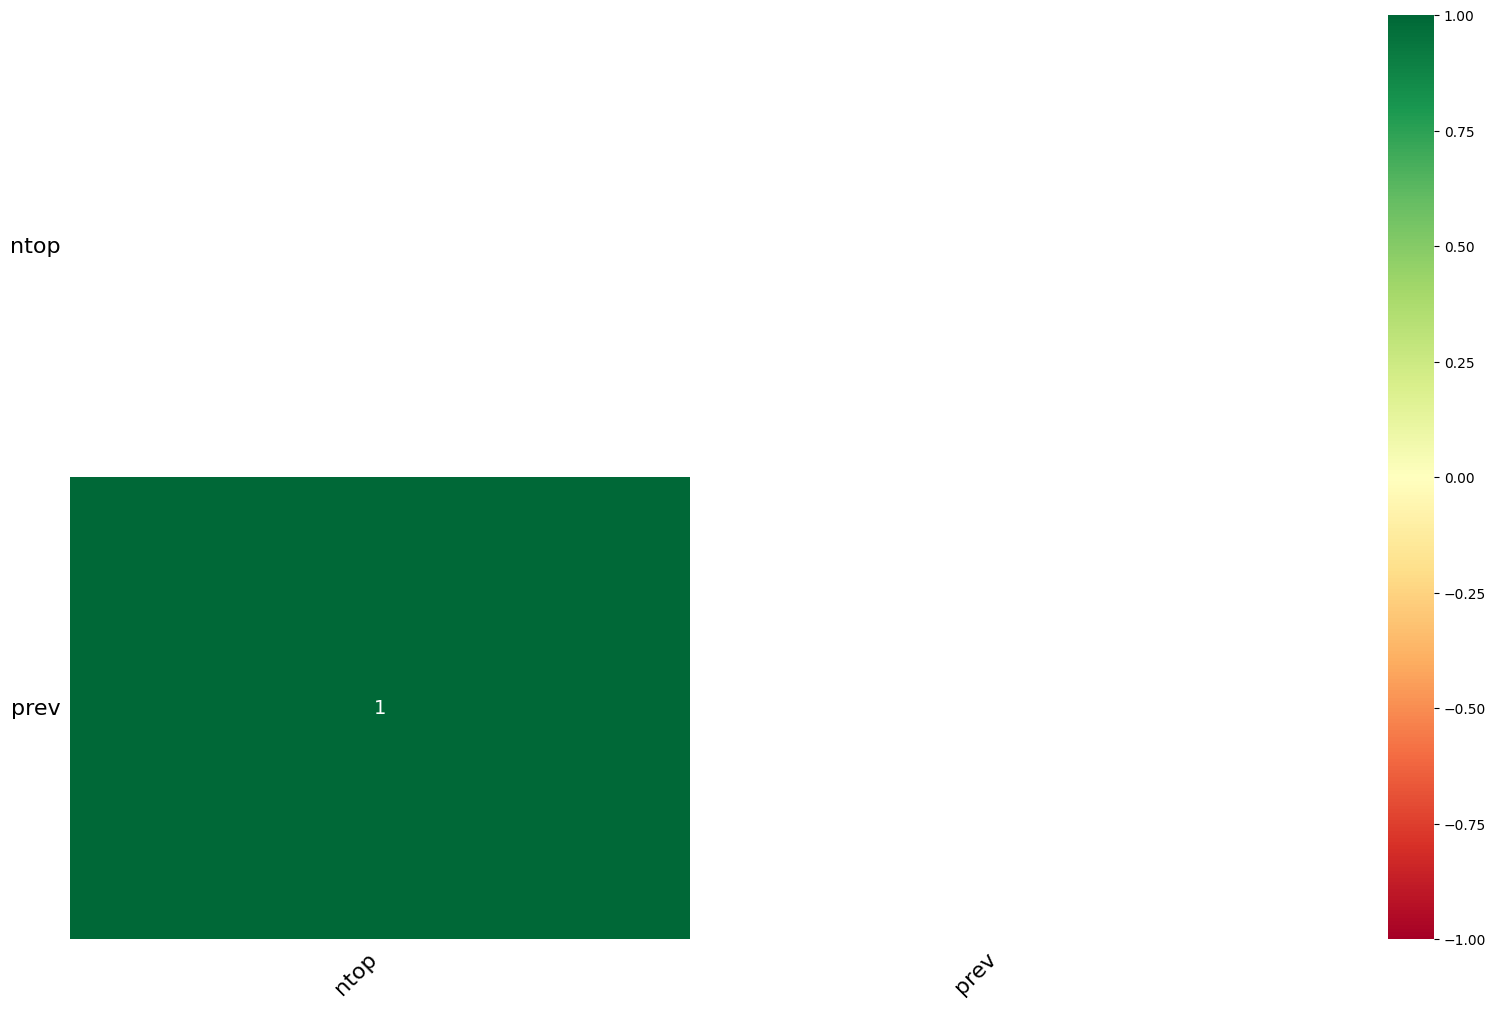

In [ ]:
msno.heatmap(pathologies[["ntop", "prev"]], cmap="RdYlGn")


In [ ]:
pathologies.dropna(subset=['prev'], inplace=True)

In [ ]:
pathologies.isna().sum()

,0
annee,0
patho_niv1,0
top,0
cla_age_5,0
sexe,0
region,0
dept,0
ntop,0
npop,0
prev,0


In [ ]:
pathologies.dtypes

,0
annee,int64
patho_niv1,object
top,object
cla_age_5,object
sexe,float64
region,float64
dept,object
ntop,float64
npop,float64
prev,float64


In [ ]:
pathologies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2206259 entries, 1 to 3024153
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   annee               int64  
 1   patho_niv1          object 
 2   top                 object 
 3   cla_age_5           object 
 4   sexe                float64
 5   region              float64
 6   dept                object 
 7   ntop                float64
 8   npop                float64
 9   prev                float64
 10  niveau_prioritaire  object 
 11  libelle_classe_age  object 
 12  libelle_sexe        object 
 13  tri                 float64
dtypes: float64(6), int64(1), object(7)
memory usage: 252.5+ MB


In [ ]:
descrip= pathologies.drop(columns=["annee", 'sexe', 'region', 'tri'])
descrip.describe()

,ntop,npop,prev
count,2.206259e+06,2.206259e+06,2.206259e+06
mean,5.221837e+03,1.308536e+05,5.908529e+00
std,1.573716e+05,1.141935e+06,1.526457e+01
min,1.000000e+01,1.000000e+01,0.000000e+00
25%,5.000000e+01,9.060000e+03,2.670000e-01
50%,2.000000e+02,1.997000e+04,9.530000e-01
75%,9.100000e+02,5.236000e+04,4.065000e+00
max,6.852589e+07,6.872923e+07,1.000000e+02


La région doit etre de type 'Object', on la transforme en 'str'

In [ ]:
pathologies['region'] = pathologies['region'].astype(str)


In [ ]:
pathologies.describe(include = object)

,patho_niv1,top,cla_age_5,region,dept,niveau_prioritaire,libelle_classe_age,libelle_sexe
count,2206259,2206259,2206259,2206259,2206259,2170838,2206259,2206259
unique,18,79,21,19,102,7,21,3
top,Maladies cardioneurovasculaires,HHP_CAT_INC,tsage,76.0,999,"2,3",tous âges,tous sexes
freq,445831,42932,141048,243969,382484,748338,141048,797222


Nous allons étudier les corrélations (Selon Pearson et Spearman) entre la prévalence d'une maladie et les différents polluants, pour ce faire nous allons créer un Dataframe ayant pour attributs Departement,prev,polluant_1,...,polluant_n

Nous allons commencer par le Cancer, nous avons choisi de travailler sur les données de pollution en 2010 et celles du cancer en 2018 car en moyenne une durée de 8 ans est nécessaire pour que les symptomes commencent à apparaitre.

In [ ]:
polluants = pollution[pollution['Annee Emission'] == 2010]['Polluant'].unique()
cancer = pathologies[(pathologies['patho_niv1'] == 'Cancers') & (pathologies['annee'] == 2018)]
prevalence_pr_departement = cancer.groupby('dept')['prev'].mean().reset_index()
prevalence_pr_departement = prevalence_pr_departement[prevalence_pr_departement['dept'] != '999']
departement_codes = {
    'AIN': '01', 'AISNE': '02', 'ALLIER': '03', 'ALPES-DE-HAUTE-PROVENCE': '04',
    'HAUTES-ALPES': '05', 'ALPES-MARITIMES': '06', 'ARDECHE': '07', 'ARDENNES': '08',
    'ARIEGE': '09', 'AUBE': '10', 'AUDE': '11', 'AVEYRON': '12', 'BOUCHES-DU-RHONE': '13',
    'CALVADOS': '14', 'CANTAL': '15', 'CHARENTE': '16', 'CHARENTE-MARITIME': '17',
    'CHER': '18', 'CORREZE': '19', "COTE-D'OR": '21', "COTES-D'ARMOR": '22',
    'CREUSE': '23', 'DORDOGNE': '24', 'DOUBS': '25', 'DROME': '26', 'EURE': '27',
    'EURE-ET-LOIR': '28', 'FINISTERE': '29', 'GARD': '30', 'HAUTE-GARONNE': '31',
    'GERS': '32', 'GIRONDE': '33', 'HERAULT': '34', 'ILLE-ET-VILAINE': '35',
    'INDRE': '36', 'INDRE-ET-LOIRE': '37', 'ISERE': '38', 'JURA': '39', 'LANDES': '40',
    'LOIR-ET-CHER': '41', 'LOIRE': '42', 'HAUTE-LOIRE': '43', 'LOIRE-ATLANTIQUE': '44',
    'LOIRET': '45', 'LOT': '46', 'LOT-ET-GARONNE': '47', 'LOZERE': '48',
    'MAINE-ET-LOIRE': '49', 'MANCHE': '50', 'MARNE': '51', 'HAUTE-MARNE': '52',
    'MAYENNE': '53', 'MEURTHE-ET-MOSELLE': '54', 'MEUSE': '55', 'MORBIHAN': '56',
    'MOSELLE': '57', 'NIEVRE': '58', 'NORD': '59', 'OISE': '60', 'ORNE': '61',
    'PAS-DE-CALAIS': '62', 'PUY-DE-DOME': '63', 'PYRENEES-ATLANTIQUES': '64',
    'HAUTES-PYRENEES': '65', 'PYRENEES-ORIENTALES': '66', 'BAS-RHIN': '67',
    'HAUT-RHIN': '68', 'RHONE': '69', 'HAUTE-SAONE': '70', 'SAONE-ET-LOIRE': '71',
    'SARTHE': '72', 'SAVOIE': '73', 'HAUTE-SAVOIE': '74', 'PARIS': '75',
    'SEINE-MARITIME': '76', 'SEINE-ET-MARNE': '77', 'YVELINES': '78', 'DEUX-SEVRES': '79',
    'SOMME': '80', 'TARN': '81', 'TARN-ET-GARONNE': '82', 'VAR': '83', 'VAUCLUSE': '84',
    'VENDEE': '85', 'VIENNE': '86', 'HAUTE-VIENNE': '87', 'VOSGES': '88', 'YONNE': '89',
    'TERRITOIRE-DE-BELFORT': '90', 'ESSONNE': '91', 'HAUTS-DE-SEINE': '92',
    'SEINE-SAINT-DENIS': '93', 'VAL-DE-MARNE': '94', "VAL-D'OISE": '95',
    'GUADELOUPE': '971', 'MARTINIQUE': '972', 'GUYANE': '973', 'LA REUNION': '974',
    'MAYOTTE': '976', 'CORSE-DU-SUD': '2A', 'HAUTE-CORSE': '2B'
}
prevalence_pr_departement['Departement'] = prevalence_pr_departement['dept'].map(
    {v: k for k, v in departement_codes.items()}
)
prevalence_pr_departement = prevalence_pr_departement.dropna(subset=['Departement']).drop(columns=['dept'])
quantite_emise_final = prevalence_pr_departement.copy()

for polluant in polluants:
    pol_2010 = pollution[(pollution['Annee Emission'] == 2010) & (pollution['Polluant'] == polluant)]
    quantite_emise = pol_2010.groupby('Departement')['Quantité'].sum().reset_index()
    quantite_emise = quantite_emise.rename(columns={'Quantité': polluant})
    quantite_emise_final = quantite_emise_final.merge(
        quantite_emise, on='Departement', how='left'
    ).fillna({polluant: 0})


<ipython-input-30-feb03b8dafd3>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


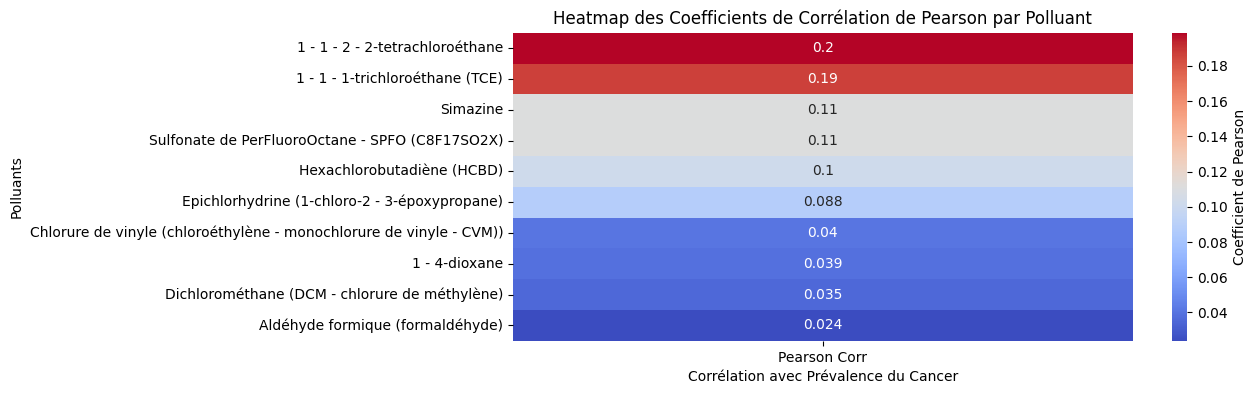

In [ ]:
# Initialisation du DataFrame pour stocker les résultats
results = pd.DataFrame(columns=['Polluant', 'Pearson Corr', 'P-valeur (Indep)'])

# Analyse des corrélations pour chaque polluant
for polluant in polluants:
    if polluant in quantite_emise_final.columns and pd.api.types.is_numeric_dtype(quantite_emise_final[polluant]):
        # Extraction des données pertinentes
        data = quantite_emise_final[['prev', polluant]].dropna()
        if len(data) > 1:  # Nécessaire pour calculer une corrélation
            corr, p_value = pearsonr(data['prev'], data[polluant])
            new_row = pd.DataFrame({'Polluant': [polluant], 'Pearson Corr': [corr], 'P-valeur (Indep)': [p_value]})
            results = pd.concat([results, new_row], ignore_index=True)

# Tri et sélection des résultats
results = results.sort_values(by='Pearson Corr', ascending=False).head(10).reset_index(drop=True)

# Visualisation des résultats sous forme de heatmap
plt.figure(figsize=(10, len(results) * 0.4))
sns.heatmap(
    results[['Pearson Corr']].set_index(results['Polluant']),
    annot=True,
    cmap='coolwarm',
    cbar_kws={'label': 'Coefficient de Pearson'}
)
plt.xlabel('Corrélation avec Prévalence du Cancer')
plt.ylabel('Polluants')
plt.title('Heatmap des Coefficients de Corrélation de Pearson par Polluant')
plt.show()



<ipython-input-31-0fbdab0b750f>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


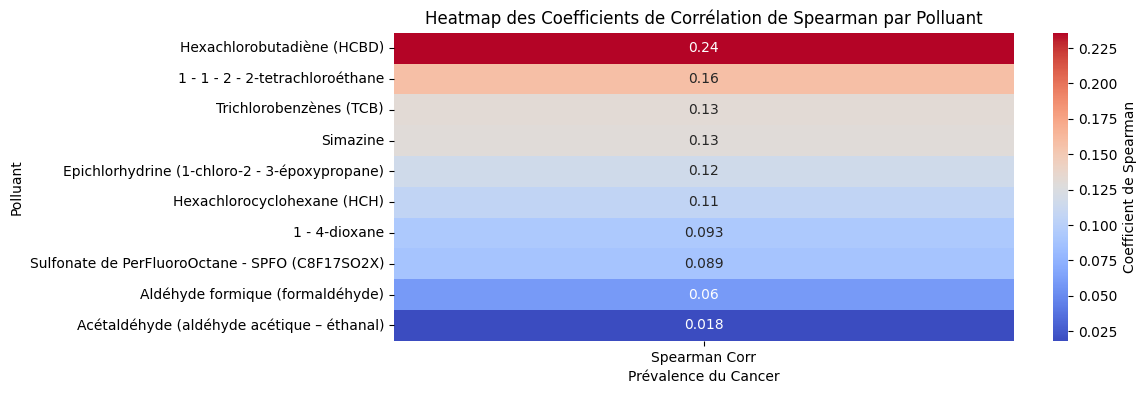

In [ ]:
results = pd.DataFrame(columns=['Polluant', 'Spearman Corr', 'P-valeur (Indep)'])

for polluant in polluants:
    if polluant in quantite_emise_final.columns:
        data = quantite_emise_final[['prev', polluant]].dropna()
        corr, p_value = spearmanr(data['prev'], data[polluant])
        new_row = pd.DataFrame({'Polluant': [polluant], 'Spearman Corr': [corr], 'P-valeur (Indep)': [p_value]})
        results = pd.concat([results, new_row], ignore_index=True)

results = results.sort_values(by='Spearman Corr', ascending=False).head(10).reset_index(drop=True)

plt.figure(figsize=(10, len(results) * 0.4))
sns.heatmap(results[['Spearman Corr']].set_index(results['Polluant']), annot=True, cmap='coolwarm', cbar_kws={'label': 'Coefficient de Spearman'})
plt.xlabel('Prévalence du Cancer')
plt.title('Heatmap des Coefficients de Corrélation de Spearman par Polluant')
plt.show()

In [ ]:
pollutant_corr_matrix = quantite_emise_final.iloc[:, 2:].corr()
threshold = 0.85
high_corr_pairs = [
    (col1, col2)
    for col1 in pollutant_corr_matrix.columns
    for col2 in pollutant_corr_matrix.columns
    if col1 != col2 and abs(pollutant_corr_matrix.loc[col1, col2]) > threshold
]
print(high_corr_pairs)


[("CO2 Total (CO2 d'origine biomasse et non biomasse)", "CO2 Total d'origine non biomasse uniquement"), ("CO2 Total (CO2 d'origine biomasse et non biomasse)", "CO2 Total d'origine biomasse uniquement"), ("CO2 Total d'origine non biomasse uniquement", "CO2 Total (CO2 d'origine biomasse et non biomasse)"), ("Sulfure d'hydrogène (H2S)", 'Phénols (Ctotal)'), ("Sulfure d'hydrogène (H2S)", "Crésol (mélange d'isomères)"), ('Demande biologique en oxygène (DBO5)', 'Phosphore total (P)'), ('Demande biologique en oxygène (DBO5)', 'Demande chimique en oxygène (DCO)'), ('Phénols (Ctotal)', "Sulfure d'hydrogène (H2S)"), ('Phénols (Ctotal)', "Crésol (mélange d'isomères)"), ('Oxydes de soufre (SOx - SO2 + SO3) (en eq. SO2)', 'Composés organiques volatils non méthaniques (COVNM)'), ('Oxydes de soufre (SOx - SO2 + SO3) (en eq. SO2)', 'Antimoine et ses composés (Sb)'), ('Oxydes de soufre (SOx - SO2 + SO3) (en eq. SO2)', 'Benzène'), ('Oxydes de soufre (SOx - SO2 + SO3) (en eq. SO2)', 'Thallium et ses comp

In [ ]:
features_to_remove = set()
for col1, col2 in high_corr_pairs:
    features_to_remove.add(col2)

quantite_emise_final_reduced = quantite_emise_final.drop(columns=features_to_remove)
print(quantite_emise_final_reduced.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 50 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   prev                                                                 101 non-null    float64
 1   Departement                                                          101 non-null    object 
 2   Ammoniac (NH3)                                                       101 non-null    float64
 3   Cadmium et ses composés (Cd)                                         101 non-null    float64
 4   Méthane (CH4)                                                        101 non-null    float64
 5   Oxydes d'azote (NOx - NO + NO2) (en eq. NO2)                         101 non-null    float64
 6   Zinc et ses composés (Zn)                                            101 non-null    float64
 7   Azote to

In [ ]:
X = quantite_emise_final_reduced.drop(columns=['prev', 'Departement'])
y = quantite_emise_final_reduced['prev']
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

features_to_remove = vif_data[vif_data["VIF"] > 10]["Feature"].tolist()
X = X.drop(columns=features_to_remove)



                                              Feature         VIF
1                        Cadmium et ses composés (Cd)  111.248555
22                         Etain et ses composés (Sn)   60.848067
3        Oxydes d'azote (NOx - NO + NO2) (en eq. NO2)   39.683358
14                Fluor et composés inorganiques (HF)   31.288370
17                        Cuivre et ses composés (Cu)   29.186757
15                       Mercure et ses composés (Hg)   27.770392
18                                            Toluène   26.410603
39                                            Xylènes   25.870283
16  Dioxines et furanes (PCDD + PCDF) (exprimés en...   22.935725
24                      Carbone organique total (COT)   19.235613
6                    Hydrochlorofluorocarbures (HCFC)   18.169269
9                        Arsenic et ses composés (As)   17.317795
5                                     Azote total (N)   17.070646
25                     Composés organohalogénés (AOX)   11.994245
29        

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Maladies cardioneurovasculaires

In [ ]:
polluants = pollution[pollution['Annee Emission'] == 2010]['Polluant'].unique()
cancer = pathologies[(pathologies['patho_niv1'] == 'Maladies cardioneurovasculaires') & (pathologies['annee'] == 2016)]
prevalence_pr_departement = cancer.groupby('dept')['prev'].mean().reset_index()
prevalence_pr_departement = prevalence_pr_departement[prevalence_pr_departement['dept'] != '999']
departement_codes = {
    'AIN': '01', 'AISNE': '02', 'ALLIER': '03', 'ALPES-DE-HAUTE-PROVENCE': '04',
    'HAUTES-ALPES': '05', 'ALPES-MARITIMES': '06', 'ARDECHE': '07', 'ARDENNES': '08',
    'ARIEGE': '09', 'AUBE': '10', 'AUDE': '11', 'AVEYRON': '12', 'BOUCHES-DU-RHONE': '13',
    'CALVADOS': '14', 'CANTAL': '15', 'CHARENTE': '16', 'CHARENTE-MARITIME': '17',
    'CHER': '18', 'CORREZE': '19', "COTE-D'OR": '21', "COTES-D'ARMOR": '22',
    'CREUSE': '23', 'DORDOGNE': '24', 'DOUBS': '25', 'DROME': '26', 'EURE': '27',
    'EURE-ET-LOIR': '28', 'FINISTERE': '29', 'GARD': '30', 'HAUTE-GARONNE': '31',
    'GERS': '32', 'GIRONDE': '33', 'HERAULT': '34', 'ILLE-ET-VILAINE': '35',
    'INDRE': '36', 'INDRE-ET-LOIRE': '37', 'ISERE': '38', 'JURA': '39', 'LANDES': '40',
    'LOIR-ET-CHER': '41', 'LOIRE': '42', 'HAUTE-LOIRE': '43', 'LOIRE-ATLANTIQUE': '44',
    'LOIRET': '45', 'LOT': '46', 'LOT-ET-GARONNE': '47', 'LOZERE': '48',
    'MAINE-ET-LOIRE': '49', 'MANCHE': '50', 'MARNE': '51', 'HAUTE-MARNE': '52',
    'MAYENNE': '53', 'MEURTHE-ET-MOSELLE': '54', 'MEUSE': '55', 'MORBIHAN': '56',
    'MOSELLE': '57', 'NIEVRE': '58', 'NORD': '59', 'OISE': '60', 'ORNE': '61',
    'PAS-DE-CALAIS': '62', 'PUY-DE-DOME': '63', 'PYRENEES-ATLANTIQUES': '64',
    'HAUTES-PYRENEES': '65', 'PYRENEES-ORIENTALES': '66', 'BAS-RHIN': '67',
    'HAUT-RHIN': '68', 'RHONE': '69', 'HAUTE-SAONE': '70', 'SAONE-ET-LOIRE': '71',
    'SARTHE': '72', 'SAVOIE': '73', 'HAUTE-SAVOIE': '74', 'PARIS': '75',
    'SEINE-MARITIME': '76', 'SEINE-ET-MARNE': '77', 'YVELINES': '78', 'DEUX-SEVRES': '79',
    'SOMME': '80', 'TARN': '81', 'TARN-ET-GARONNE': '82', 'VAR': '83', 'VAUCLUSE': '84',
    'VENDEE': '85', 'VIENNE': '86', 'HAUTE-VIENNE': '87', 'VOSGES': '88', 'YONNE': '89',
    'TERRITOIRE-DE-BELFORT': '90', 'ESSONNE': '91', 'HAUTS-DE-SEINE': '92',
    'SEINE-SAINT-DENIS': '93', 'VAL-DE-MARNE': '94', "VAL-D'OISE": '95',
    'GUADELOUPE': '971', 'MARTINIQUE': '972', 'GUYANE': '973', 'LA REUNION': '974',
    'MAYOTTE': '976', 'CORSE-DU-SUD': '2A', 'HAUTE-CORSE': '2B'
}
prevalence_pr_departement['Departement'] = prevalence_pr_departement['dept'].map(
    {v: k for k, v in departement_codes.items()}
)
prevalence_pr_departement = prevalence_pr_departement.dropna(subset=['Departement']).drop(columns=['dept'])
quantite_emise_final = prevalence_pr_departement.copy()

for polluant in polluants:
    pol_2010 = pollution[(pollution['Annee Emission'] == 2010) & (pollution['Polluant'] == polluant)]
    quantite_emise = pol_2010.groupby('Departement')['Quantité'].sum().reset_index()
    quantite_emise = quantite_emise.rename(columns={'Quantité': polluant})
    quantite_emise_final = quantite_emise_final.merge(
        quantite_emise, on='Departement', how='left'
    ).fillna({polluant: 0})


<ipython-input-37-b1b48d8be616>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


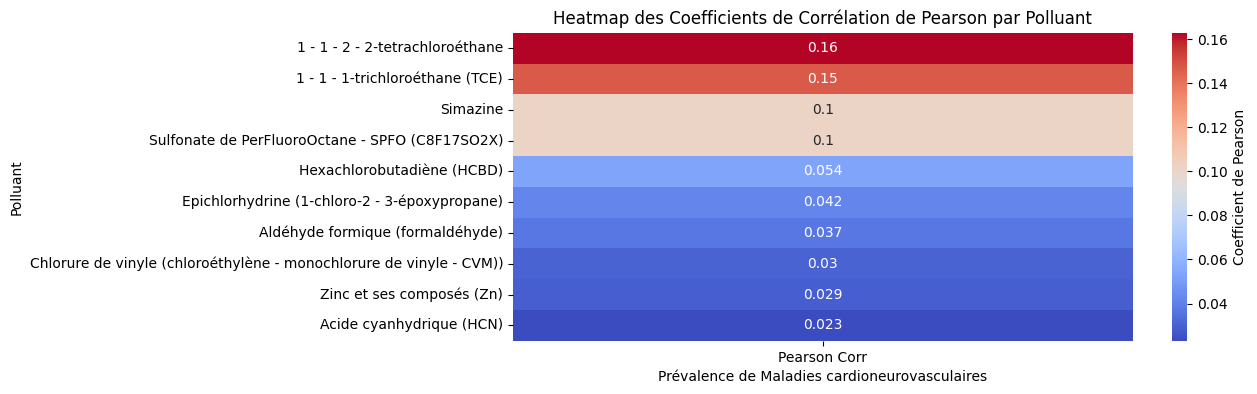

In [ ]:
results = pd.DataFrame(columns=['Polluant', 'Pearson Corr', 'P-valeur (Indep)'])

for polluant in polluants:
    if polluant in quantite_emise_final.columns:
        data = quantite_emise_final[['prev', polluant]].dropna()
        corr, p_value = pearsonr(data['prev'], data[polluant])
        new_row = pd.DataFrame({'Polluant': [polluant], 'Pearson Corr': [corr], 'P-valeur (Indep)': [p_value]})
        results = pd.concat([results, new_row], ignore_index=True)

results = results.sort_values(by='Pearson Corr', ascending=False).head(10).reset_index(drop=True)

plt.figure(figsize=(10, len(results) * 0.4))
sns.heatmap(results[['Pearson Corr']].set_index(results['Polluant']), annot=True, cmap='coolwarm', cbar_kws={'label': 'Coefficient de Pearson'})
plt.xlabel('Prévalence de Maladies cardioneurovasculaires')
plt.title('Heatmap des Coefficients de Corrélation de Pearson par Polluant')
plt.show()

<ipython-input-38-17901a6a43a9>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


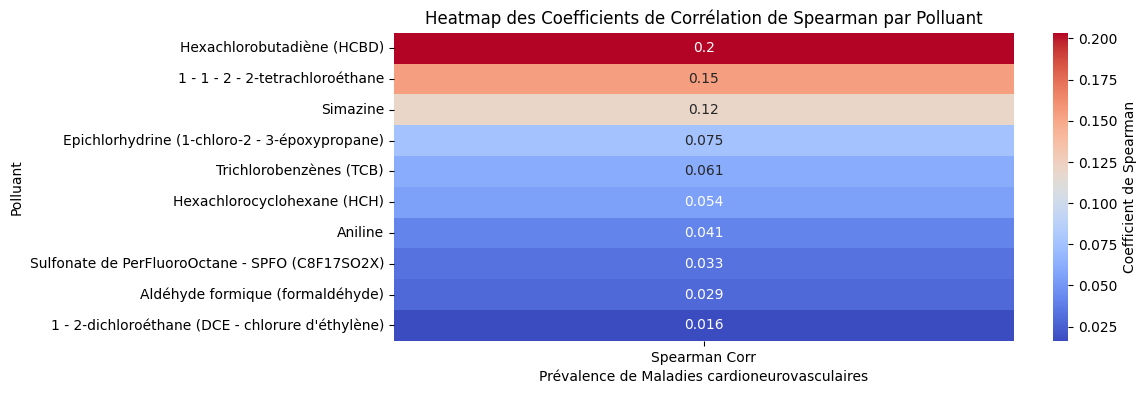

In [ ]:
results = pd.DataFrame(columns=['Polluant', 'Spearman Corr', 'P-valeur (Indep)'])

for polluant in polluants:
    if polluant in quantite_emise_final.columns:
        data = quantite_emise_final[['prev', polluant]].dropna()
        corr, p_value = spearmanr(data['prev'], data[polluant])
        new_row = pd.DataFrame({'Polluant': [polluant], 'Spearman Corr': [corr], 'P-valeur (Indep)': [p_value]})
        results = pd.concat([results, new_row], ignore_index=True)

results = results.sort_values(by='Spearman Corr', ascending=False).head(10).reset_index(drop=True)

plt.figure(figsize=(10, len(results) * 0.4))
sns.heatmap(results[['Spearman Corr']].set_index(results['Polluant']), annot=True, cmap='coolwarm', cbar_kws={'label': 'Coefficient de Spearman'})
plt.xlabel('Prévalence de Maladies cardioneurovasculaires')
plt.title('Heatmap des Coefficients de Corrélation de Spearman par Polluant')
plt.show()

Les corrélations binaires sont assez faibles. Nous essaierons de faire une étude de multicorrélation après.

Nous verrons maintenant les corrélations entre les differentes quantités des differents polluants.

In [ ]:
pollutant_corr_matrix = quantite_emise_final.iloc[:, 2:].corr()
threshold = 0.85
high_corr_pairs = [
    (col1, col2)
    for col1 in pollutant_corr_matrix.columns
    for col2 in pollutant_corr_matrix.columns
    if col1 != col2 and abs(pollutant_corr_matrix.loc[col1, col2]) > threshold
]
print(high_corr_pairs)


[("CO2 Total (CO2 d'origine biomasse et non biomasse)", "CO2 Total d'origine non biomasse uniquement"), ("CO2 Total (CO2 d'origine biomasse et non biomasse)", "CO2 Total d'origine biomasse uniquement"), ("CO2 Total d'origine non biomasse uniquement", "CO2 Total (CO2 d'origine biomasse et non biomasse)"), ("Sulfure d'hydrogène (H2S)", 'Phénols (Ctotal)'), ("Sulfure d'hydrogène (H2S)", "Crésol (mélange d'isomères)"), ('Demande biologique en oxygène (DBO5)', 'Phosphore total (P)'), ('Demande biologique en oxygène (DBO5)', 'Demande chimique en oxygène (DCO)'), ('Phénols (Ctotal)', "Sulfure d'hydrogène (H2S)"), ('Phénols (Ctotal)', "Crésol (mélange d'isomères)"), ('Oxydes de soufre (SOx - SO2 + SO3) (en eq. SO2)', 'Composés organiques volatils non méthaniques (COVNM)'), ('Oxydes de soufre (SOx - SO2 + SO3) (en eq. SO2)', 'Antimoine et ses composés (Sb)'), ('Oxydes de soufre (SOx - SO2 + SO3) (en eq. SO2)', 'Benzène'), ('Oxydes de soufre (SOx - SO2 + SO3) (en eq. SO2)', 'Thallium et ses comp

In [ ]:
features_to_remove = set()
for col1, col2 in high_corr_pairs:
    features_to_remove.add(col2)

quantite_emise_final_reduced = quantite_emise_final.drop(columns=features_to_remove)
print(quantite_emise_final_reduced.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 50 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   prev                                                                 101 non-null    float64
 1   Departement                                                          101 non-null    object 
 2   Ammoniac (NH3)                                                       101 non-null    float64
 3   Cadmium et ses composés (Cd)                                         101 non-null    float64
 4   Méthane (CH4)                                                        101 non-null    float64
 5   Oxydes d'azote (NOx - NO + NO2) (en eq. NO2)                         101 non-null    float64
 6   Zinc et ses composés (Zn)                                            101 non-null    float64
 7   Azote to

In [ ]:
X = quantite_emise_final_reduced.drop(columns=['prev', 'Departement'])
y = quantite_emise_final_reduced['prev']
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False))

features_to_remove = vif_data[vif_data["VIF"] > 10]["Feature"].tolist()
X = X.drop(columns=features_to_remove)



                                              Feature         VIF
1                        Cadmium et ses composés (Cd)  111.248555
22                         Etain et ses composés (Sn)   60.848067
3        Oxydes d'azote (NOx - NO + NO2) (en eq. NO2)   39.683358
14                Fluor et composés inorganiques (HF)   31.288370
17                        Cuivre et ses composés (Cu)   29.186757
15                       Mercure et ses composés (Hg)   27.770392
18                                            Toluène   26.410603
39                                            Xylènes   25.870283
16  Dioxines et furanes (PCDD + PCDF) (exprimés en...   22.935725
24                      Carbone organique total (COT)   19.235613
6                    Hydrochlorofluorocarbures (HCFC)   18.169269
9                        Arsenic et ses composés (As)   17.317795
5                                     Azote total (N)   17.070646
25                     Composés organohalogénés (AOX)   11.994245
29        

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


<ipython-input-43-fafcc69dc4b9>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top10_dept_pathologies = dept_pathologies.groupby('patho_niv1', group_keys=False).apply(lambda x: x.nlargest(10, 'prev'))


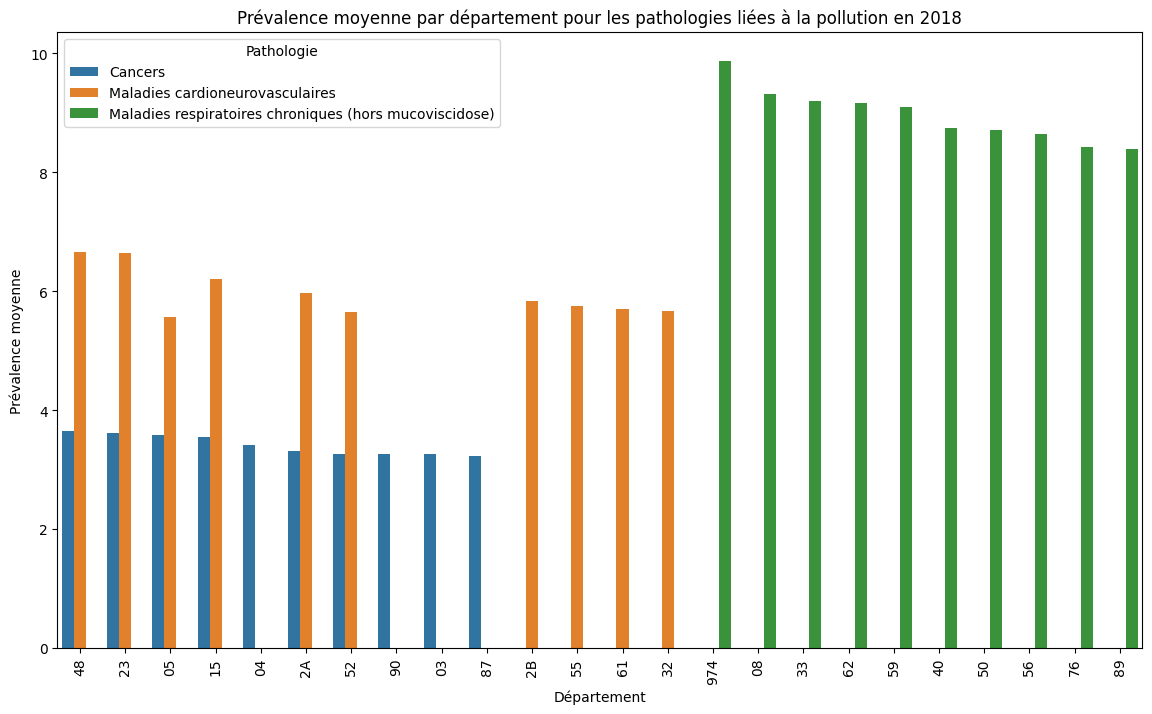

In [ ]:
pollution_related_pathologies = ['Cancers','Maladies cardioneurovasculaires','Maladies respiratoires chroniques (hors mucoviscidose)']
pathologies_relevant = pathologies[(pathologies['patho_niv1'].isin(pollution_related_pathologies)) & (pathologies['annee'] == 2018) ]
dept_pathologies = pathologies_relevant.groupby(['dept', 'patho_niv1'])['prev'].mean().reset_index()
top10_dept_pathologies = dept_pathologies.groupby('patho_niv1', group_keys=False).apply(lambda x: x.nlargest(10, 'prev'))
plt.figure(figsize=(14, 8))
sns.barplot(data=top10_dept_pathologies, x='dept', y='prev', hue='patho_niv1')
plt.title("Prévalence moyenne par département pour les pathologies liées à la pollution en 2018")
plt.xlabel("Département")
plt.ylabel("Prévalence moyenne")
plt.legend(title="Pathologie")
plt.xticks(rotation=90)
plt.show()


In [ ]:
polluant_counts = pollution[pollution['Annee Emission']==2010]['Polluant'].value_counts().reset_index()
polluant_counts.columns = ['Polluant', 'Count']
top_polluants = polluant_counts.head(10)
print(top_polluants)


                                            Polluant  Count
0  CO2 Total (CO2 d'origine biomasse et non bioma...   1104
1        CO2 Total d'origine non biomasse uniquement   1001
2                                     Ammoniac (NH3)    851
3  Composés organiques volatils non méthaniques (...    657
4                  Demande chimique en oxygène (DCO)    491
5               Demande biologique en oxygène (DBO5)    461
6                          Zinc et ses composés (Zn)    381
7                        Nickel et ses composés (Ni)    302
8       Oxydes d'azote (NOx - NO + NO2) (en eq. NO2)    275
9            CO2 Total d'origine biomasse uniquement    250


<ipython-input-45-f6477cbc6aee>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_polluants, x='Count', y='Polluant', palette='viridis')


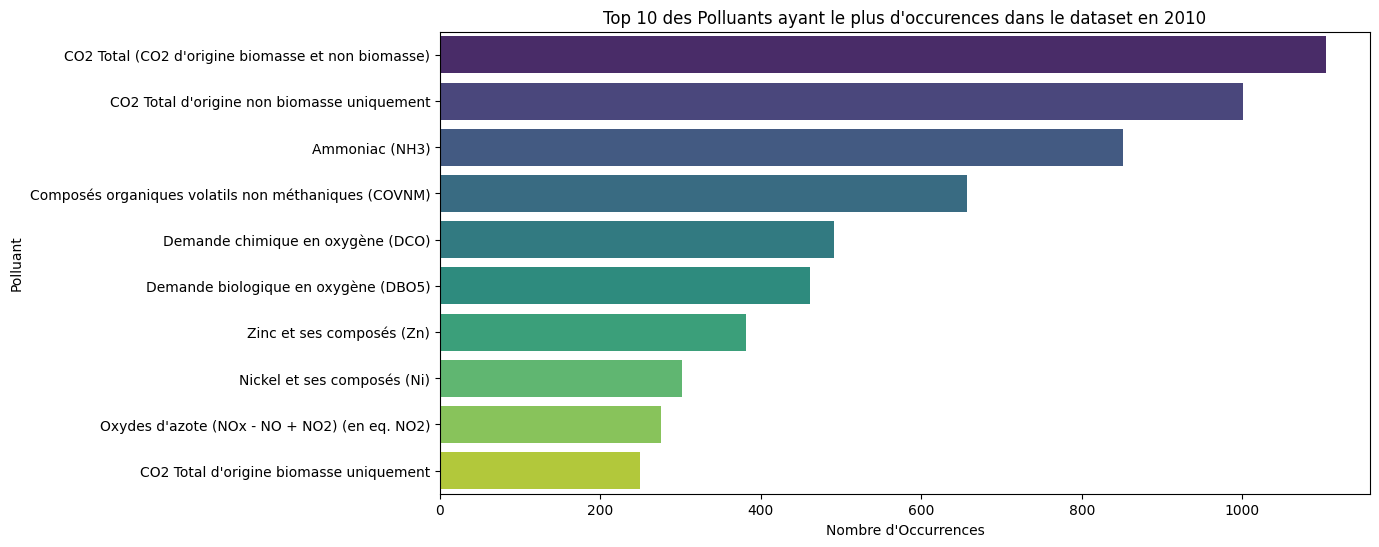

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_polluants, x='Count', y='Polluant', palette='viridis')
plt.title("Top 10 des Polluants ayant le plus d'occurences dans le dataset en 2010")
plt.xlabel('Nombre d\'Occurrences')
plt.ylabel('Polluant')
plt.show()

<ipython-input-46-e1bec4897c88>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top10_dept_pathologies = dept_quantite.groupby('Polluant', group_keys=False).apply(lambda x: x.nlargest(10, 'Quantité'))


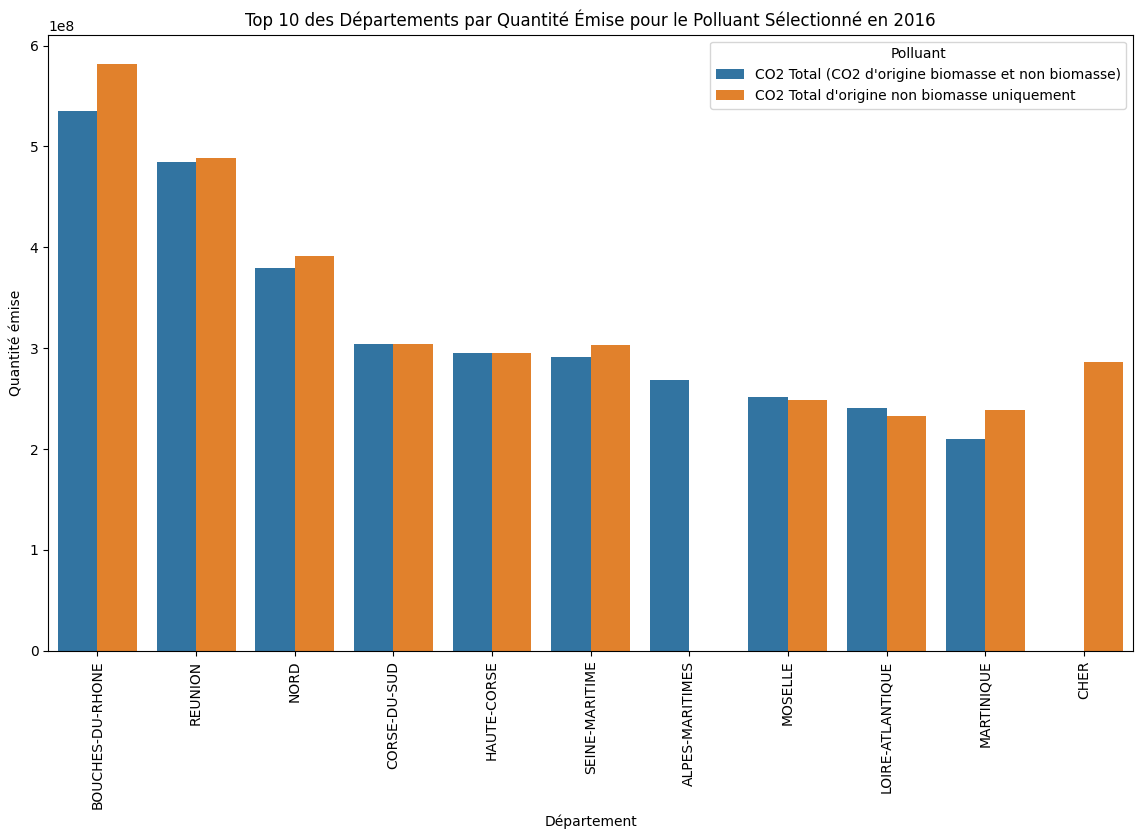

In [ ]:
polluant_cible = [top_polluants['Polluant'].iloc[0],top_polluants['Polluant'].iloc[1]]
quantite_polluant = pollution[(pollution['Polluant'].isin(polluant_cible)) & (pollution['Annee Emission'] == 2016)]
dept_quantite = quantite_polluant.groupby(['Departement', 'Polluant'])['Quantité'].mean().reset_index()
top10_dept_pathologies = dept_quantite.groupby('Polluant', group_keys=False).apply(lambda x: x.nlargest(10, 'Quantité'))

plt.figure(figsize=(14, 8))
sns.barplot(data=top10_dept_pathologies, x='Departement', y='Quantité', hue='Polluant')
plt.title("Top 10 des Départements par Quantité Émise pour le Polluant Sélectionné en 2016")
plt.xlabel("Département")
plt.ylabel("Quantité émise")
plt.xticks(rotation=90)
plt.show()

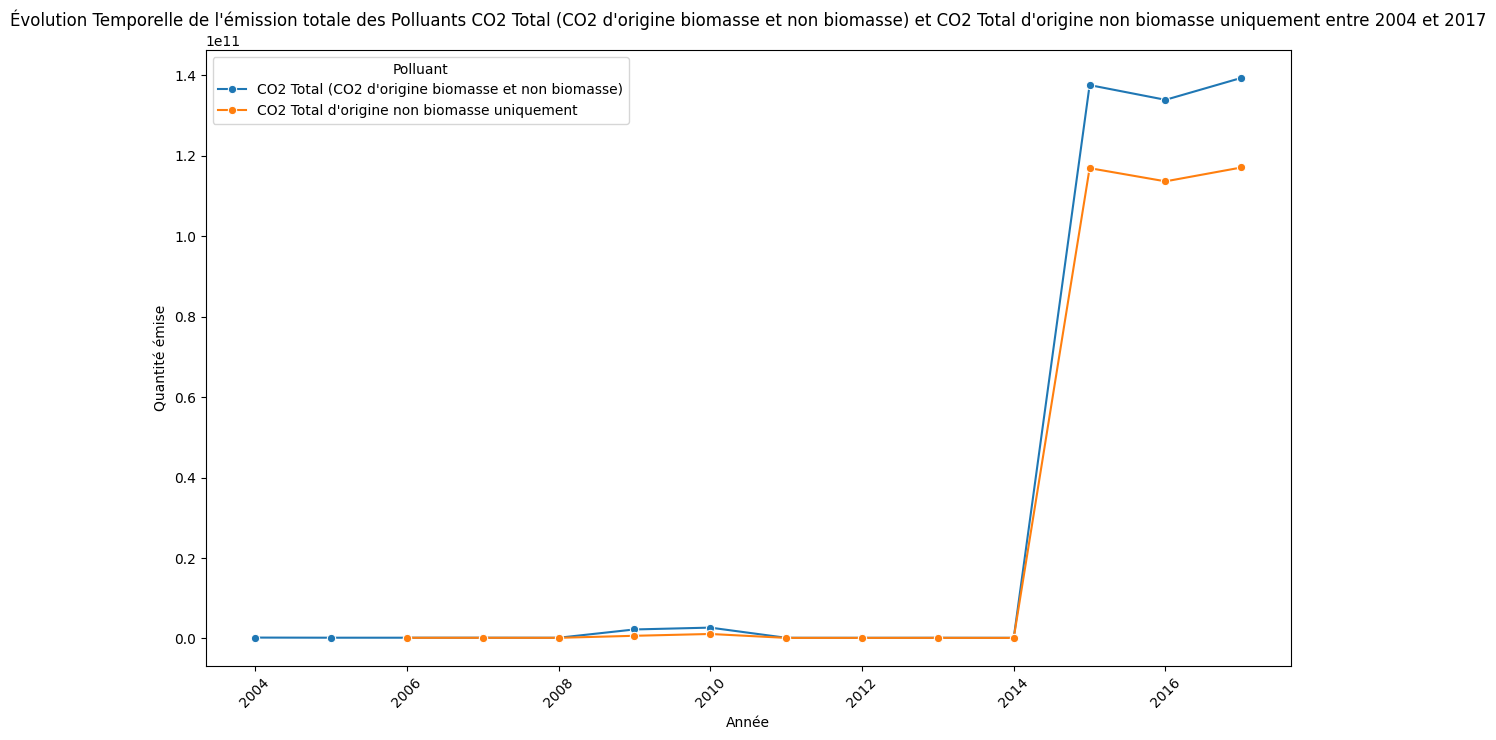

In [ ]:
polluant_cible = [top_polluants['Polluant'].iloc[0], top_polluants['Polluant'].iloc[1]]
quantite_polluant = pollution[(pollution['Polluant'].isin(polluant_cible)) & (pollution['Annee Emission'].between(2004, 2017))]
quantite_annee_polluant = quantite_polluant.groupby(['Annee Emission', 'Polluant'])['Quantité'].sum().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(data=quantite_annee_polluant, x='Annee Emission', y='Quantité', hue='Polluant', marker='o')
plt.title(f"Évolution Temporelle de l'émission totale des Polluants {polluant_cible[0]} et {polluant_cible[1]} entre 2004 et 2017")
plt.xlabel("Année")
plt.ylabel("Quantité émise")
plt.xticks(rotation=45)
plt.show()